In [115]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy
from shapely.geometry import point

In [2]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning'

In [49]:
#loading in the current enrollment for only the 2024-25 school year
current_enrollment = pd.read_csv(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\DPS_count_pu_grades.csv')
current_enrollment_2024 = current_enrollment[current_enrollment['year_str']=='2024-2025']
current_enrollment_2024.head()

#current_enrollment['geo_id_b2020'].unique()

,fall_year,spring_year,year_str,geo_id_b2020,geo_nm_b2020,grade,count,basez
0,2024,2025.0,2024-2025,3.706300e+14,Block 1000,-2,2.0,0.0
4,2024,2025.0,2024-2025,3.706300e+14,Block 1000,0,2.0,2.0
6,2024,2025.0,2024-2025,3.706300e+14,Block 1000,1,3.0,3.0
8,2024,2025.0,2024-2025,3.706300e+14,Block 1000,2,2.0,2.0
14,2024,2025.0,2024-2025,3.706300e+14,Block 1000,4,1.0,0.0


In [42]:
#now we want to only show the 5th, 6th, 7th, and 8th grade - the grades that will be in high school in 2028-29
mask = current_enrollment['grade'].isin([5,6,7,8])
hs_2028 = current_enrollment_2024[mask].dropna()
hs_2028 = hs_2028.drop(columns=['fall_year','spring_year','year_str','geo_id_b2020'])
hs_2028.head(10)

C:\Users\olubl\AppData\Local\Temp\ipykernel_18812\3691576906.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hs_2028 = current_enrollment_2024[mask].dropna()


,geo_nm_b2020,grade,count,basez
19,Block 1000,5,2.0,1.0
22,Block 1000,6,1.0,1.0
25,Block 1000,7,1.0,1.0
29,Block 1000,8,1.0,0.0
51,Block 1001,8,2.0,2.0
73,Block 1002,5,1.0,1.0
77,Block 1002,8,1.0,0.0
93,Block 1003,6,2.0,1.0
95,Block 1003,7,1.0,1.0
97,Block 1003,8,1.0,1.0


In [5]:
#merging identical rows to get student counts by block and grade
columns_to_group = (['geo_nm_b2020','grade'])
hs_2028 = hs_2028.groupby(columns_to_group,as_index=False).sum()   #as_index=False preserves the columns we are grouping by
ms = {5,6,7,8}
hs_2028[hs_2028['grade'].isin(ms)]['count'].sum()  #there are this many dps students in 5th-8th grade now

8775.0

In [6]:
hs_2028.head()
#now use marketshare for projections

,geo_nm_b2020,grade,count,basez
0,Block 1000,5,70.0,44.0
1,Block 1000,6,55.0,35.0
2,Block 1000,7,50.0,28.0
3,Block 1000,8,64.0,36.0
4,Block 1001,5,55.0,35.0


In [123]:
#read in the planning units and their centroids
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\PU_2425_918\PU_2425_918.shp')
dps_pu = dps_pu.to_crs(epsg = 3857)
dps_pu['centroid'] = dps_pu['geometry'].centroid
dps_pu.head(3)

,OBJECTID,pu_2324_84,X,Y,TIMS_PU,pu_2425_91,Join_Count,TARGET_FID,Join_Cou_1,TARGET_F_1,...,sch_id_g_2,choice_hs,type_hs,region_202,region_2_1,pu_2425__2,Shape_Leng,Shape_Area,geometry,centroid
0,1.0,1,2.049028e+06,893128.606346,PU589,1,1,1,1,1,...,356,None,High School Base Assignment Zone,North,North,820,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+...",POINT (-8.78e+06 4.33e+06)
1,2.0,2,2.039923e+06,835434.121317,PU401,2,1,2,1,2,...,356,None,High School Base Assignment Zone,North,North,664,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+...",POINT (-8.78e+06 4.31e+06)
2,3.0,3,2.058005e+06,797649.028742,PU782.0,3,1,3,1,3,...,368,Energy & Sustainability,High School Base Assignment Zone,East,East,1,18314.823119,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+...",POINT (-8.77e+06 4.29e+06)


In [143]:
#read in the school locations
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs

,OBJECTID,facilityid,sch_id6,sch_id,name,address,phone,agencyurl,operhours,spectype,...,region_base,region_physical,calendar_2324,calendar_2425,choice_2324,choice_2425,choice_2526,x_ncplane,y_ncplane,geometry
10,11,27253,320368,368,Southern High School,"800 Clayton Road Durham, NC 27703",919-560-3968,http://southern.dpsnc.net/pages/Southern_High,9:15am - 4:15pm,Magnet School,...,east,east,Traditional,Traditional,Energy & Sustainability,Energy & Sustainability,Energy & Sustainability,2050552.39,818903.23,POINT (-8.78e+06 4.3e+06)
14,15,87951,320325,325,Hillside High School,3727 Fayetteville Street Durham NC 27707,919-560-3925,http://hillside.dpsnc.net/pages/Hillside_High,9:15am - 4:15pm,None,...,southeast,southeast,Traditional,Traditional,International Baccalaureate,International Baccalaureate,International Baccalaureate,2028531.50,801909.91,POINT (-8.78e+06 4.29e+06)
55,56,6494,320356,356,Northern High School,4622 N Roxboro Road Durham NC 27712,919-560-3956,http://northern.dpsnc.net/pages/Northern_High,9:15am - 4:15pm,None,...,north,north,Traditional,Traditional,None,None,None,2029463.13,841220.63,POINT (-8.78e+06 4.31e+06)
56,57,12065,320365,365,Riverside High School,"3218 Rose of Sharon Road Durham, NC 27712",919-560-3965,http://www.edlinesites.net/pages/Riverside_High,9:15am - 4:15pm,None,...,central,north,Traditional,Traditional,None,None,None,2018531.26,843582.30,POINT (-8.79e+06 4.31e+06)
57,58,76194,320312,312,Jordan High School,6806 Garrett Road Durham NC 27707,919-560-3912,http://jordan.dpsnc.net/pages/Jordan_High,9:15am - 4:15pm,None,...,southwest,southwest,Traditional,Traditional,None,None,None,2011193.93,790759.00,POINT (-8.79e+06 4.29e+06)


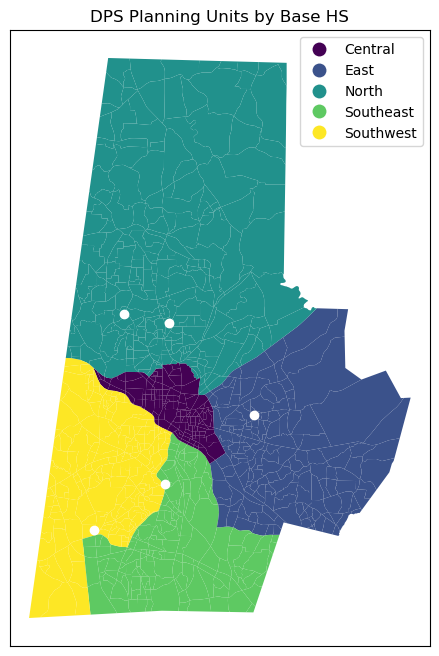

In [91]:
fig,ax = plt.subplots(figsize=(6,8))

dps_pu.plot(
    column = 'region_2_1',
    legend = True,
    cmap = 'viridis',
    ax = ax
)
dps_base_hs.plot(ax=plt.gca(),zorder = 1, color = 'white')


ax.set_xticks([])
ax.set_yticks([])


plt.title('DPS Planning Units by Base HS')
plt.show()

In [ ]:
#considering changing marketshare from ms to hs

In [147]:
#building iterative boundary assigment
dps_base_hs.iloc[0,28]
for i,hs in enumerate(dps_base_hs['name']):
    for j,unit in enumerate(dps_pu['OBJECTID']):
        distance = dps_base_hs.iloc[i,28].distance(dps_pu.loc[j,'centroid'])
        #dps_pu.loc[j,hs] = distance
dps_pu.head()

#assign high school based on distance next

,OBJECTID,pu_2324_84,X,Y,TIMS_PU,pu_2425_91,Join_Count,TARGET_FID,Join_Cou_1,TARGET_F_1,...,pu_2425__2,Shape_Leng,Shape_Area,geometry,centroid,Southern High School,Hillside High School,Northern High School,Riverside High School,Jordan High School
0,1.0,1,2.049028e+06,893128.606346,PU589,1,1,1,1,1,...,820,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+...",POINT (-8.78e+06 4.33e+06),28096.799821,35365.646970,20990.321930,22001.290024,41262.838649
1,2.0,2,2.039923e+06,835434.121317,PU401,2,1,2,1,2,...,664,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+...",POINT (-8.78e+06 4.31e+06),7420.115356,13376.571143,4507.345598,8626.692122,20047.006101
2,3.0,3,2.058005e+06,797649.028742,PU782.0,3,1,3,1,3,...,1,18314.823119,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+...",POINT (-8.77e+06 4.29e+06),8507.739210,11201.842165,19664.632210,22853.119446,17793.669578
3,4.0,4,2.003222e+06,772895.737307,PU201.0,4,1,4,1,4,...,404,29282.100083,4.684140e+07,"POLYGON ((-8.79e+06 4.29e+06, -8.79e+06 4.29e+...",POINT (-8.79e+06 4.28e+06),24874.460245,14510.641232,27639.657311,27324.139031,7380.026012
4,5.0,5,2.067334e+06,828244.230730,PU646,5,1,5,1,5,...,133,60685.151474,1.497046e+08,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06...",POINT (-8.77e+06 4.3e+06),7236.944097,17670.578126,15081.648489,19271.766366,25430.845056
